In [46]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.metrics import confusion_matrix
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# 데이터 준비

In [47]:
# 데이터 경로 설정
base_path = Path("/aiffel/aiffel/jellyfish/Train_Test_Valid")
train_dir = base_path / "Train"
valid_dir = base_path / "valid"
test_dir = base_path / "test"

# 이미지 파일 경로와 레이블 수집 함수
def get_files_labels(directory):
    # 지원하는 이미지 확장자 목록
    image_extensions = ["*.jpg","*.JPG","*.PNG ","*.jpeg", "*.png"]
    
    # 모든 확장자를 포함한 파일 수집
    all_files = []
    for ext in image_extensions:
        all_files.extend(directory.rglob(ext))
    
    file_paths = [str(f) for f in all_files]
    labels = [f.parent.name for f in all_files]
    return file_paths, labels

# 데이터셋별 파일 경로 및 레이블 로드
X_train, y_train = get_files_labels(train_dir)
X_val, y_val = get_files_labels(valid_dir)
X_test, y_test = get_files_labels(test_dir)

print(f"Train 데이터: {len(X_train)}개")
print(f"Validation 데이터: {len(X_val)}개")
print(f"Test 데이터: {len(X_test)}개")


Train 데이터: 900개
Validation 데이터: 39개
Test 데이터: 40개


## 이미지 전처리

In [48]:
# 클래스 이름 정의 및 매핑 생성
class_names = sorted(set(y_train + y_val + y_test))
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

# 이미지를 로드하고 전처리하는 함수 정의
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])  # MobileNetV3 입력 크기
    return tf.keras.applications.mobilenet_v3.preprocess_input(img)

# TensorFlow Dataset 생성 함수 정의
def create_tf_dataset(paths, labels):
    labels = [class_to_idx[label] for label in labels]
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(lambda p, l: (load_image(p), l))  # 이미지 로드 및 전처리 적용
    return dataset

# Train/Validation/Test 데이터셋 생성
train_ds = create_tf_dataset(X_train, y_train).shuffle(1000).batch(32).prefetch(2)
valid_ds = create_tf_dataset(X_val, y_val).batch(32).prefetch(2)
test_ds = create_tf_dataset(X_test, y_test).batch(32)


# 모델 구성

In [49]:
# MobileNetV3Large 모델 로드 및 고정
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet'
)
base_model.trainable = False  # 사전 학습된 가중치 고정

# 사용자 정의 분류기 추가
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # 클래스 수에 맞게 출력층 설정
])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               163968    
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

# 모델 학습

In [50]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
]

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
29/29 [==============================] - 7s 82ms/step - loss: 1.1151 - accuracy: 0.6533 - val_loss: 0.9556 - val_accuracy: 0.6410
Epoch 2/30
29/29 [==============================] - 2s 41ms/step - loss: 0.2428 - accuracy: 0.9122 - val_loss: 0.8474 - val_accuracy: 0.6667
Epoch 3/30
29/29 [==============================] - 2s 41ms/step - loss: 0.1392 - accuracy: 0.9600 - val_loss: 0.8073 - val_accuracy: 0.6923
Epoch 4/30
29/29 [==============================] - 2s 42ms/step - loss: 0.1113 - accuracy: 0.9689 - val_loss: 0.8064 - val_accuracy: 0.6923
Epoch 5/30
29/29 [==============================] - 2s 40ms/step - loss: 0.0993 - accuracy: 0.9778 - val_loss: 0.8071 - val_accuracy: 0.6667
Epoch 6/30
29/29 [==============================] - 2s 41ms/step - loss: 0.0866 - accuracy: 0.9767 - val_loss: 0.8102 - val_accuracy: 0.7179
Epoch 7/30
29/29 [==============================] - 2s 42ms/step - loss: 0.0647 - accuracy: 0.9867 - val_loss: 0.8223 - val_accuracy: 0.6923
Epoch 8/30
29

 # 결과 시각화

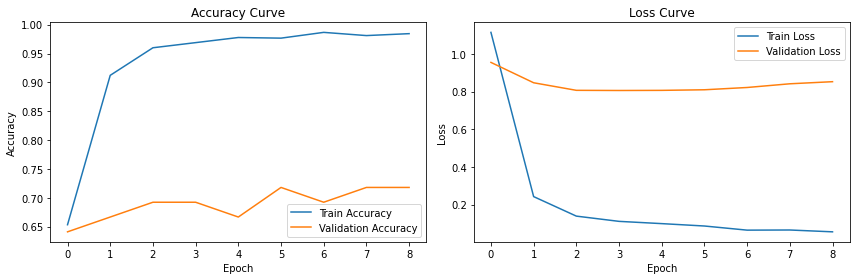

In [51]:
plt.figure(figsize=(12, 4))

# 정확도 곡선 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 곡선 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 평가

In [52]:
# 테스트 데이터 평가
test_loss, test_acc = model.evaluate(test_ds)
print(f"테스트 손실: {test_loss:.4f}")
print(f"테스트 정확도: {test_acc:.4f}")

2/2 [==============================] - 0s 25ms/step - loss: 0.4060 - accuracy: 0.8750
테스트 손실: 0.4060
테스트 정확도: 0.8750


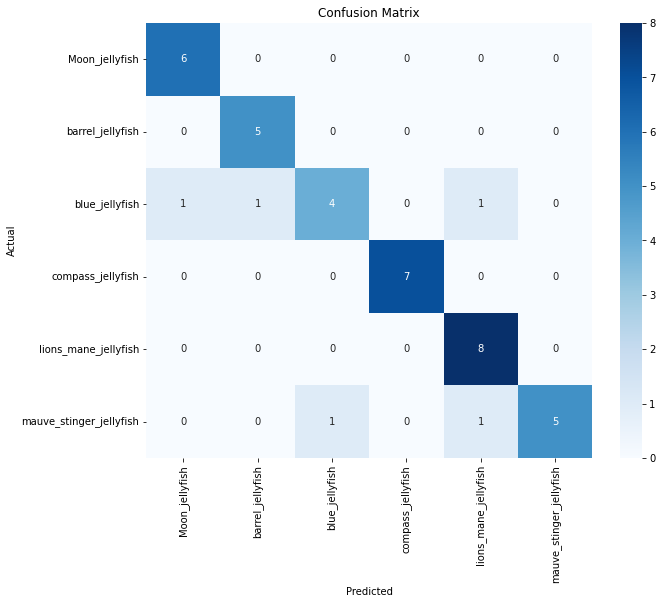

In [53]:
# 혼동 행렬 계산 및 시각화
y_pred_classes = np.concatenate([np.argmax(model.predict(x), axis=1) for x, _ in test_ds])
y_true_classes = np.concatenate([y for _, y in test_ds])

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [60]:
def predict_image(img_path):
    img = load_image(img_path)  # 이미지 로드 및 전처리 수행
    img_array = tf.expand_dims(img, axis=0)  # 배치 차원 추가

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    
    return class_names[predicted_index], np.max(predictions[0])

# 테스트 이미지 예측 실행 예시:
img_path = "/aiffel/aiffel/jellyfish/Moon_jellyfish/01.jpg"
predicted_class, confidence = predict_image(img_path)
print(f"예측 결과: {predicted_class} (신뢰도: {confidence:.2%})")


예측 결과: Moon_jellyfish (신뢰도: 91.46%)


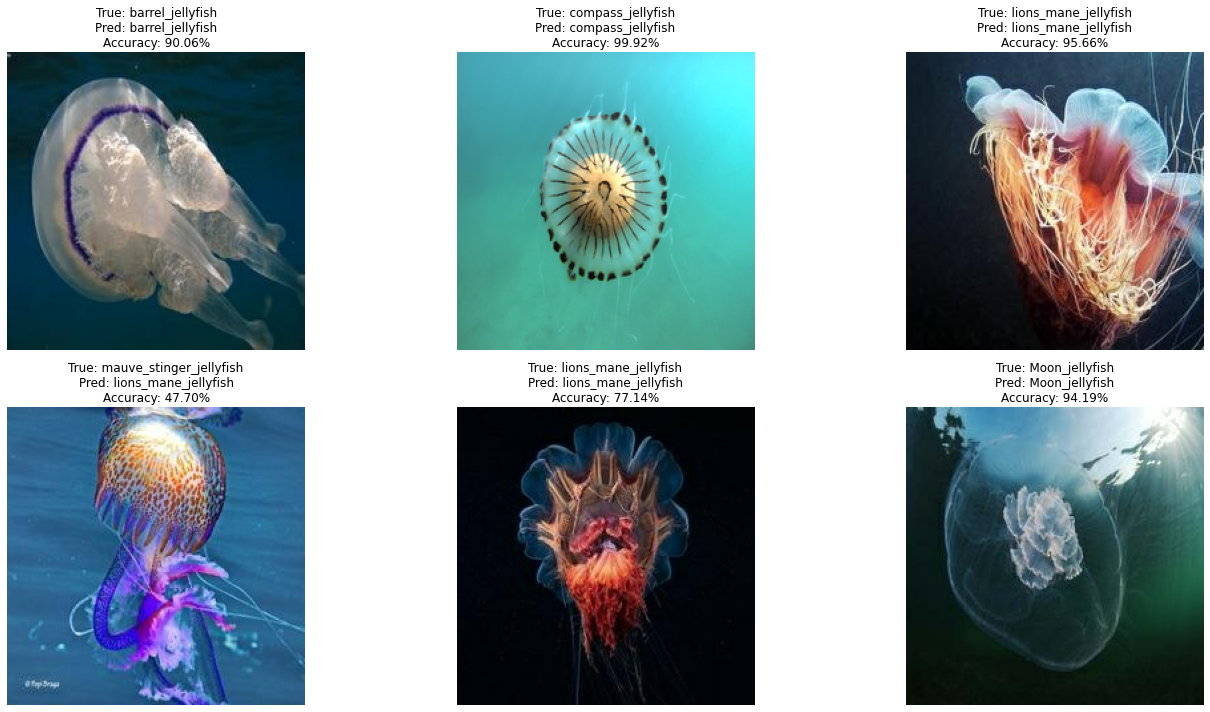

In [38]:
import random
import matplotlib.pyplot as plt

def predict_random_images(num_samples=5):
    # 무작위 샘플 선택
    random_indices = random.sample(range(len(X_test)), num_samples)
    selected_paths = [X_test[i] for i in random_indices]
    true_labels = [y_test[i] for i in random_indices]

    # 시각화 설정
    plt.figure(figsize=(20, 10))
    
    for i, (path, true_label) in enumerate(zip(selected_paths, true_labels)):
        # 예측 수행
        predicted_class, confidence = predict_image(path)
        
        # 원본 이미지 로드 (시각화용)
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = img.numpy().astype("uint8")

        # 결과 시각화
        plt.subplot(2, 3, i+1)  # 2행 3열 그리드
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_class}\nAccuracy: {confidence:.2%}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 6개 이미지 예측 실행
predict_random_images(6)